In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Off-policy Monte-Carlo Control

In [60]:
def getGreedyPolicy(Q):
    return np.argmax(Q,axis=-1)

gamma = 0.99

def OffPolicyMCControl(episode, Q, C, target_policy, getBehaviourDist):
    b_policy = getBehaviourDist()
    G = 0.0
    W = 1.0
    converged = True
    step = len(episode)-1
    for state, action, reward in reversed(episode):
        G = gamma*G + reward
        C[state][action] += W
        q = Q[state][action]
        Q[state][action] += W/C[state][action] * (G-Q[state][action])
        converged = converged and abs(q - Q[state][action]) < CONVERGENCE_ERROR
        target_policy[state] = np.argmax(Q[state])
        if target_policy[state] != action: break
        W *= 1.0/b_policy[state][action]
        step -= 1
    
    #print("\repisode length:{:7}; steps used:{:3}".format(len(episode),len(episode)-step), 
    #      end='', flush=True)
    return converged

#### Some geometry

In [3]:
def getVectors(base, line):
    return np.array([line[0]-base, line[1]-base])
    
def det(v1,v2):
    return v1[0]*v2[1]-v1[1]*v2[0]

def is_intersection(l1, l2):
    return (det(*getVectors(l1[0],l2)) < 0) != (det(*getVectors(l1[1],l2)) < 0) \
           and (det(*getVectors(l2[0],l1)) < 0) != (det(*getVectors(l2[1],l1)) < 0)

### Implementation of RaceTrack environment

In [4]:
MAX_VELOCITY = 4
MIN_VELOCITY = 0

rt_contour_1 = [
    [3,0],[3,3],[2,3],[2,10],[1,10],[1,18],[0,18],[0,28],[1,28],[1,29],[2,29],
    [2,31],[3,31],[3,32],[17,32],[17,26],[10,26],[10,25],[9,25],[9,0],[3,0]
]
start_line_1 = (3,0,9,1)
finish_line_1 = (16,26,17,32)
track_shape_1 = (17,32)
ACCELERATION =  [[1,-1],  [1,0],  [1,1],
                 [0,-1],  [0,0],  [0,1],
                [-1,-1], [-1,0], [-1,1]]
ACTIONS_NUM = len(ACCELERATION)

REWARD = -1
CONVERGENCE_ERROR = 0.02


In [5]:
def rt_getStartPosition(start_line):
    return (np.random.randint(start_line[0], start_line[2]),0,0,0)

def is_finished(finish_line, position, next_position):
    return is_intersection(np.array([(finish_line[0],finish_line[1]),
                                     (finish_line[0],finish_line[3])]),
                           np.array([np.array(position)+0.5, 
                                     np.array(next_position)+0.5]))

def is_runout(contour, position, next_position):
    it = iter(contour)
    p1 = next(it)
    for p2 in it:
        if is_intersection(np.array([p1,p2]), 
                           np.array([np.array(position)+0.5, 
                                     np.array(next_position)+0.5])):
            return True
        p1 = p2
    return False

def rt_getTransition(track_contour, state, action, finish_line, 
                     getStartPosition=lambda: rt_getStartPosition(start_line_1)):
    accel = ACCELERATION[action]
    next_velocity = np.clip([state[2]+accel[0],state[3]+accel[1]], 
                            MIN_VELOCITY, MAX_VELOCITY)
    if (next_velocity == [0,0]).all():
        next_velocity = np.array([state[2],state[3]])
    position = np.array([state[0],state[1]])
    next_position = position + next_velocity

    if is_finished(finish_line, position, next_position):
        return (True,getStartPosition())

    if not is_runout(track_contour, position, next_position):
        next_state = tuple(next_position) + tuple(next_velocity)
    else:
        next_state = getStartPosition()
        
    return (False,next_state)
    

#### Test of RaceTrack environment

In [ ]:
rt_getTransition(rt_contour_1, (12,30,3,1), 8, finish_line_1, 
                 getStartPosition=lambda: rt_getStartPosition(start_line_1))

### Run Racetrack learning 

In [27]:
import sys
sys.path.append('..')
import SeqGen

In [61]:
QShape = track_shape_1 + (MAX_VELOCITY+1, MAX_VELOCITY+1, ACTIONS_NUM)
Q = (np.random.random(QShape)-0.5)*0.001 - 300.0

In [62]:
sequence = SeqGen.SequenceGeneratorPlus(
                SeqGen.EpsilonGreedyPolicy(Q, 0.1),
                lambda: rt_getStartPosition(start_line_1),
                lambda s,a: rt_getTransition(
                        rt_contour_1, s, a, finish_line_1, 
                        getStartPosition=lambda: rt_getStartPosition(start_line_1))
                    + (REWARD,),
                episodes_max=100000
               )

In [63]:
def MC_run(sequence, Q, C):
    conv_count = 0
    it = iter(sequence)
    while True:
        episode = []
        try: 
            while True:
                st,is_term,st_nx,ac,rw = next(it)
                episode.append((st,ac,rw))
                if is_term: break
        except StopIteration:
            print("\nSequence terminated.")
            break
            
        if len(episode) == 0: break

        t_policy = getGreedyPolicy(Q)
    
        if OffPolicyMCControl(episode, Q, C, t_policy, sequence.get_action.getDistribution):
            conv_count += 1
        else: 
            conv_count = 0
        if conv_count >= 500:
            print("\nConvergence reached.")
            break
        print(" Episode #: {}\r".format(sequence.episode_i-1), end='', flush=True)
        
    print("\nEpisodes generated: {}".format(sequence.episode_i-1))

In [64]:
C = np.zeros(dtype=np.float, shape=Q.shape)
MC_run(sequence, Q, C)

 Episode #: 100000
Sequence terminated.

Episodes generated: 100000


### Plot the optimal paths

In [8]:
# The same as getGreedyPolicy but with incapsulation
class ImmutableGreedyPolicy:
    def __init__(self, Q):
        self.action = np.argmax(Q,axis=-1);
        
    def __call__(self, state):
        return self.action[state]
    

In [75]:
epi = start_line_1[0]
def startPosition():
    global epi
    return (epi,0,0,0)

test_gen = SeqGen.SequenceGeneratorPlus(
    ImmutableGreedyPolicy(Q), 
    startPosition,
    lambda s,a: rt_getTransition(rt_contour_1, s, a, finish_line_1, 
                        getStartPosition=lambda: rt_getStartPosition(start_line_1))
                    + (REWARD,),
    episodes_max = start_line_1[2]-start_line_1[0],
    episode_maxlen = 20
    )

traces = []
episode = []
for state, is_terminal, next_state, action, reward in test_gen:
    episode.append(state[0:2])
    if is_terminal:
        traces.append(np.array(episode)+0.5)
        episode = []
        epi += 1

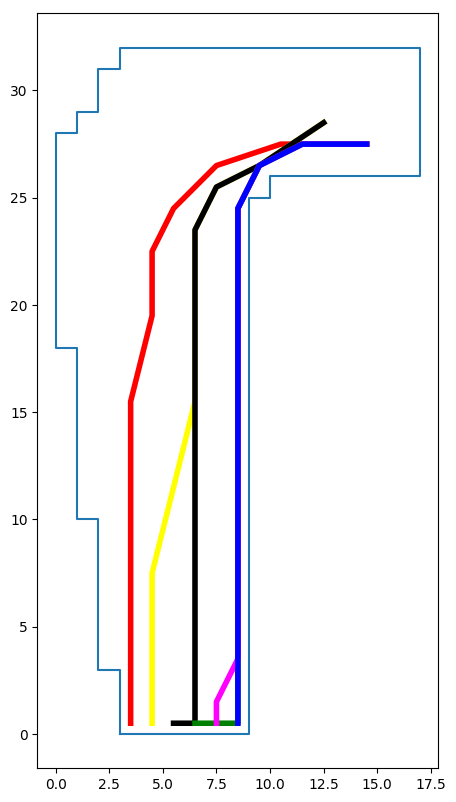

In [76]:
f = plt.figure(num=None, figsize=(8,10), dpi=100, facecolor='w', edgecolor='k')
plt.axes().set_aspect('equal')
cont = np.array(rt_contour_1)
plt.plot(cont[:,0], cont[:,1], figure=f)
cols = ['red','yellow','black','green','magenta','blue']
i = 0
for trace in traces:
    plt.plot(trace[:,0], trace[:,1], figure=f, linewidth=4.0, color=cols[i])
    i += 1

#### Some testing stuff

In [ ]:
sequence.get_action.getDistribution()[12, 18, 3, 0]

In [65]:
np.save("Q_100K",Q)
np.save("C_100K",C)

In [74]:
Q = np.load("Q_100K.npy")
C = np.load("C_100K.npy")